## Import libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import datetime

## Call the dataset and clean it

In [ ]:
raw_df = pd.read_csv("Food_Establishment_Inspection_Data.csv")
cols = { k:k.replace(' ','_').lower() for k in raw_df.keys()}

raw_df = raw_df.rename(columns=cols)
raw_df.city=raw_df.city.str.upper()
raw_df.drop(['program_identifier','inspection_business_name','inspection_serial_num','violation_record_id','business_id'], axis=1);
raw_df["inspection_date"]=pd.to_datetime(raw_df["inspection_date"])
raw_df['weekday'] = raw_df.inspection_date.dt.day_name()
raw_df.loc[raw_df['longitude'] > 122, 'longitude'] *=-1

not_valid_inspection_result_rows=raw_df[(raw_df.inspection_result !='Unsatisfactory') & (raw_df.inspection_result !='Complete') &
(raw_df.inspection_result !='Incomplete') & (raw_df.inspection_result !='Satisfactory')]
raw_df.drop(not_valid_inspection_result_rows.index, inplace=True)

dropindex = raw_df[raw_df['inspection_score']<0 ].index
raw_df.drop(dropindex, inplace=True)
raw_df['name'] = raw_df.name.str.strip()

insp_df = raw_df.reindex()
insp_df['inspection_closed_business'].replace({False: 0, True: 1}, inplace=True)
insp_df['name'] = insp_df['name'].str.upper()

insp_df_vio_freq = insp_df.groupby('violation_description')['inspection_date'].count().reset_index().rename(columns={'inspection_date': 'Violation Frequency '})
insp_df_vio_freq.to_csv('insp_df_vio_freq.csv')

## EDA Phase

### The most frequent of violations

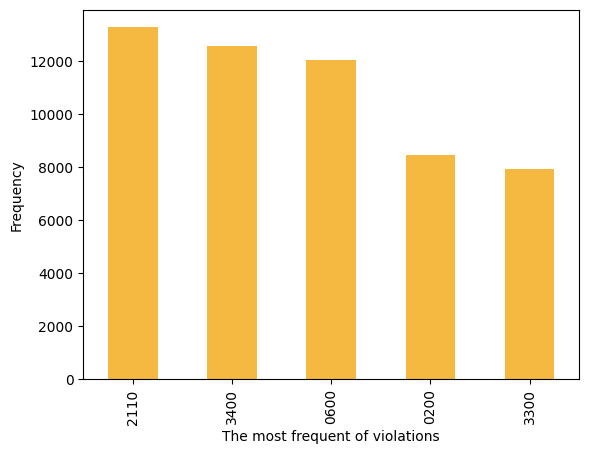

In [100]:
df_vio_freq = pd.read_csv('insp_df_vio_freq.csv')
df_vio_freq_min = df_vio_freq.nsmallest(5, 'violation_frequency')
df_vio_freq_max = df_vio_freq.nlargest(5, 'violation_frequency')

x_values=['2110','3400', '0600', '0200', '3300']
ax=df_vio_freq_max.plot(kind='bar', x='violation_description', y='violation_frequency', legend='', color='#f5b942')
ax.set_xticklabels(x_values)
plt.xlabel('The most frequent of violations')
plt.ylabel('Frequency')
# plt.savefig("The most frequent of violations.png")

### Inspection Score Average per Month

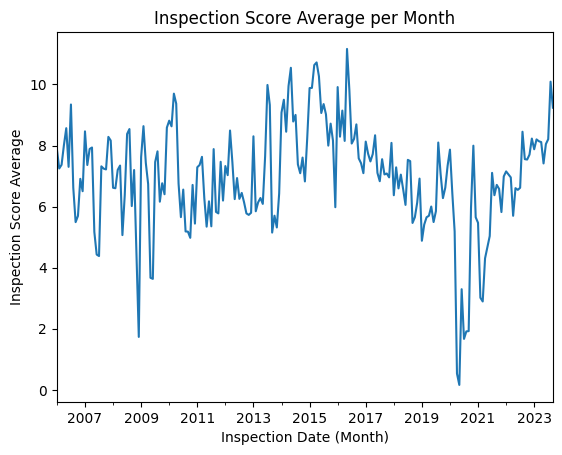

In [33]:
grouped_df=insp_df.groupby(['name', 'inspection_date', 'inspection_closed_business'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df_time_series = grouped_df.set_index('inspection_date')
grouped_df_time_series['inspection_score'].resample('M').mean().plot()
plt.title('Inspection Score Average per Month')
plt.xlabel('Inspection Date (Month)')
plt.ylabel('Inspection Score Average')
#plt.savefig("Inspection Score Average per Month.png")

### Grade Average per Inspection Closed Business

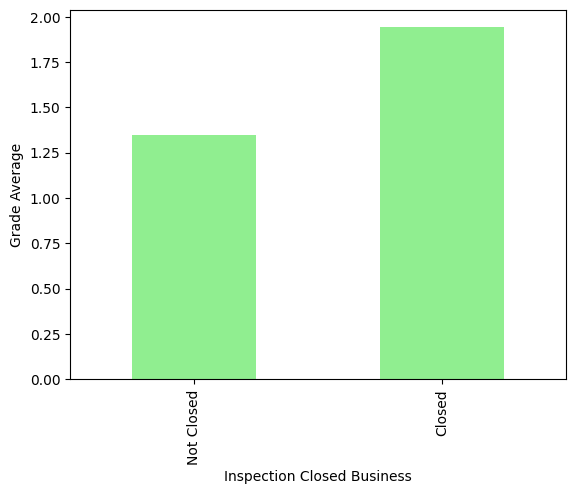

In [34]:
grouped_df_grade=insp_df.groupby(['name', 'inspection_date', 'inspection_closed_business', 'grade'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df_grade_mean_score= grouped_df_grade.groupby('inspection_closed_business')['grade'].mean()
x_values=['Not Closed','Closed']
ax=grouped_df_grade_mean_score.plot(kind='bar', x='inspection_closed_business', y='grade', legend='', color='#90EE90')
ax.set_xticklabels(x_values)
plt.xlabel('Inspection Closed Business')
plt.ylabel('Grade Average')
#plt.savefig("Grade Average per Inspection Closed Business.png")

### Inspection Score Average per Inspection Closed Business

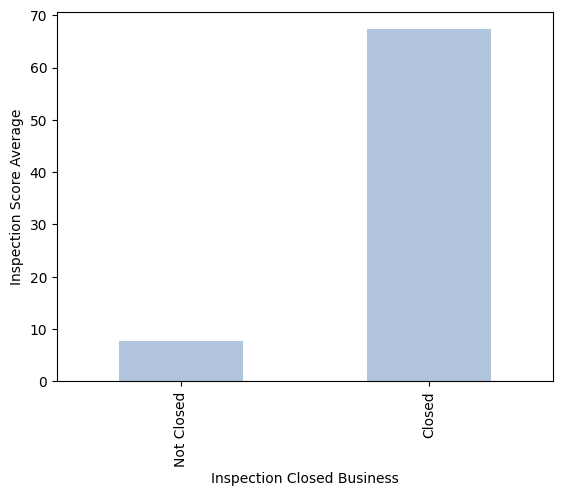

In [36]:
grouped_df_grade=insp_df.groupby(['name', 'inspection_date', 'inspection_closed_business', 'grade'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df_mean_score = grouped_df_grade.groupby('inspection_closed_business')['inspection_score'].mean().reset_index()

x_values=['Not Closed','Closed']
ax=grouped_df_mean_score.plot(kind='bar', x='inspection_closed_business', y='inspection_score', legend='', color='lightsteelblue')
ax.set_xticklabels(x_values)
plt.xlabel('Inspection Closed Business')
plt.ylabel('Inspection Score Average')
#plt.savefig("Inspection Score Average per Inspection Closed Business.png")

### Inspection Number per Seasons

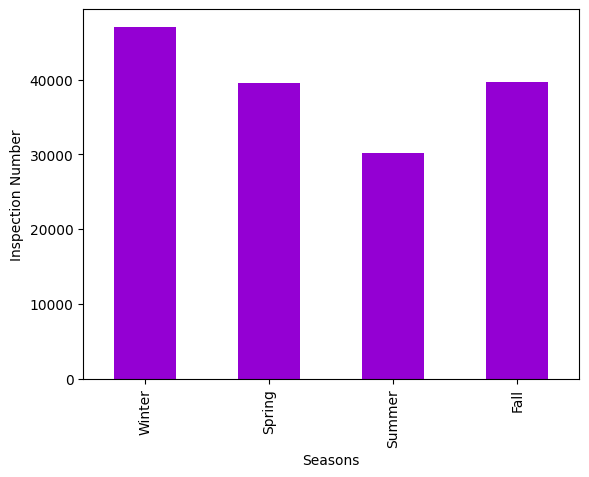

In [75]:
season_inspec_filter_df = insp_df[['name', 'inspection_date']]
season_inspec_df = season_inspec_filter_df.groupby(['name', 'inspection_date']).sum().reset_index()
season_inspec_time_series = season_inspec_df.set_index('inspection_date')
season_inspec_time_series_df=season_inspec_time_series['name'].resample('Q').count().reset_index()
season_inspec_df = season_inspec_time_series_df.groupby([season_inspec_time_series_df['inspection_date'].dt.month.rename('month')])['name'].sum().reset_index()
x_values=['Winter','Spring', 'Summer', 'Fall']
ax=season_inspec_df.plot(kind='bar', x='month', y='name', legend='', color='#9400D3')
ax.set_xticklabels(x_values)
plt.xlabel('Seasons')
plt.ylabel('Inspection Number')
#plt.savefig("Inspection Number per Seasons.png")

### Inspection Closed Business percent in each grades

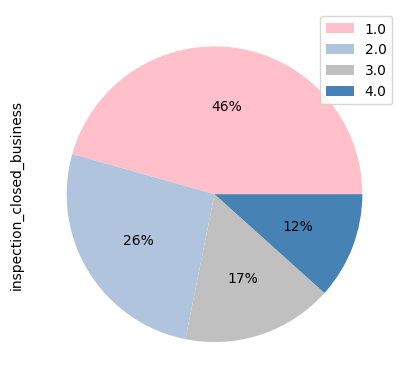

<Figure size 640x480 with 0 Axes>

In [66]:
grouped_df_grade_close=grouped_df_grade.groupby('grade')['inspection_closed_business'].count()
grouped_df_grade_score = grouped_df_grade.loc[grouped_df_grade['inspection_closed_business']==1]
grouped_df_grade_score_ = grouped_df_grade_score.groupby('grade')['inspection_closed_business'].count().reset_index()

A = grouped_df_grade_score_.set_index('grade')
colors=['pink', 'lightsteelblue', 'silver', 'steelblue']
A.plot(kind='pie', subplots=True, colors = colors, autopct='%1.0f%%', labeldistance=None)
plt.show()
#plt.savefig("Inspection Closed Business percent in each grades.png")

### Number of closed business in each grades

In [38]:
grouped_df_grade_score_.set_index('grade')

,inspection_closed_business
grade,
1.0,47
2.0,27
3.0,17
4.0,12


### Impact of Covid-19 Pandemic on Handwashing Violation

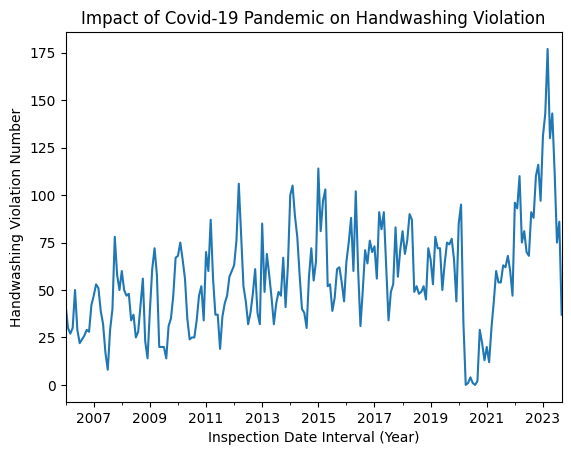

In [40]:

df_vio_desc = insp_df.loc[(insp_df['violation_description'].str.contains('hand')==True) & (insp_df['violation_description'].str.contains('wash')==True),['inspection_date', 'violation_description']]
df_vio_desc_time_series = df_vio_desc.set_index('inspection_date')
df_vio_desc_time_series['violation_description'].resample('M').count().plot()
plt.title('Impact of Covid-19 Pandemic on Handwashing Violation')
plt.xlabel('Inspection Date Interval (Year)')
plt.ylabel('Handwashing Violation Number')
#plt.savefig("Impact of Covid-19 Pandemic on Handwashing Violation.png")

### Number of inspection per Month

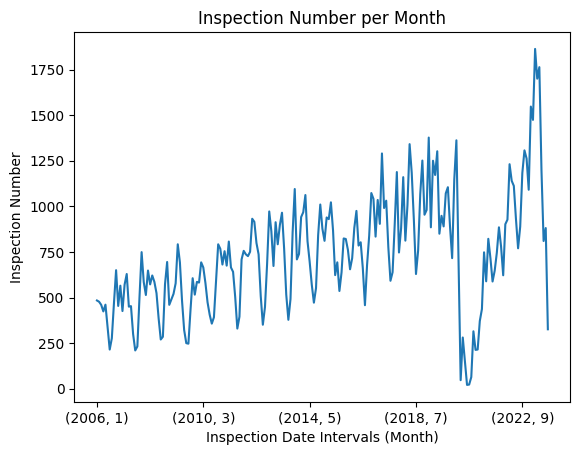

In [42]:
grouped_df=insp_df.groupby(['name', 'inspection_date', 'inspection_closed_business'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df['year'] = grouped_df['inspection_date'].dt.year
grouped_df['month'] = grouped_df['inspection_date'].dt.month
grouped_time = grouped_df.groupby(['year', 'month']).size()
grouped_time.plot()
plt.title('Inspection Number per Month')
plt.xlabel('Inspection Date Intervals (Month)')
plt.ylabel('Inspection Number')
#plt.savefig("Inspection Number per Month.png")

### Inspection score per Grade

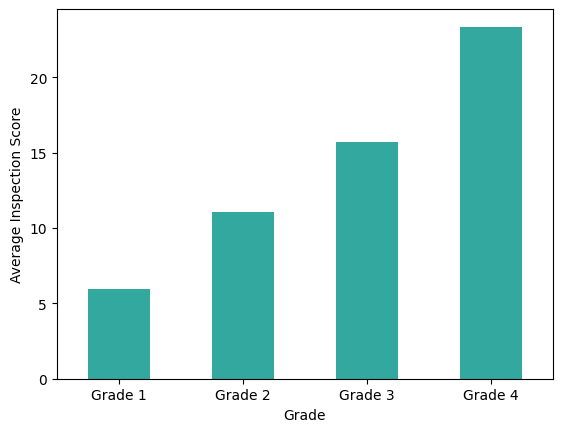

In [18]:
grouped_df_grade=insp_df.groupby(['name', 'inspection_date', 'grade'])['violation_points'].sum().reset_index().rename(columns={'violation_points': 'inspection_score'})
grouped_df_grade_mean_score = grouped_df_grade.groupby('grade')['inspection_score'].mean().reset_index()
x_values=['Grade 1','Grade 2', 'Grade 3', 'Grade 4']
ax=grouped_df_grade_mean_score.plot(kind='bar', x='grade', y='inspection_score', legend='', color='#32a89e', rot=0)
ax.set_xticklabels(x_values)
plt.xlabel('Grade')
plt.ylabel('Average Inspection Score')
# plt.savefig("Inspection score per Grade.png")

### Inspections Number per Weekdays

In [ ]:
insp_df["inspection_date"]=pd.to_datetime(insp_df["inspection_date"])
insp_df['weekday'] = insp_df.inspection_date.dt.day_name()
inspection_weekdays = insp_df.drop_duplicates('name')
inspection_weekdays = insp_df.groupby('weekday').agg(count_weekday=('weekday','count'))
inspection_weekdays.plot(kind='bar', xlabel='weekday', ylabel='count', rot=45, title='Inspection times on weekdays')

### Counting the closed business

In [ ]:
my_df = insp_df.groupby(['name', 'latitude', 'longitude', 'inspection_date', 'inspection_closed_business']).sum().reset_index()
my_df_revised = my_df.loc[:, ['name', 'latitude', 'longitude', 'inspection_date', 'inspection_closed_business']]
my_df_revised_closed_business=my_df_revised.groupby(['name', 'latitude', 'longitude'])['inspection_closed_business'].sum().reset_index().rename(columns={'inspection_closed_business': 'close_count'})

no_closed_business = my_df_revised_closed_business.loc[my_df_revised_closed_business['close_count'] == 0]
one_closed_business= my_df_revised_closed_business.loc[my_df_revised_closed_business['close_count'] == 1]
two_closed_business= my_df_revised_closed_business.loc[my_df_revised_closed_business['close_count'] == 2]
three_closed_business= my_df_revised_closed_business.loc[my_df_revised_closed_business['close_count'] == 3]
four_closed_business= my_df_revised_closed_business.loc[my_df_revised_closed_business['close_count'] == 4]

one_closed_business.to_csv('one_closed_business.csv')
two_closed_business.to_csv('two_closed_business.csv')
three_closed_business.to_csv('three_closed_business.csv')
four_closed_business.to_csv('four_closed_business.csv')